# Auto ML

In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import utils.plot as plot 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

d:\rockhead_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Load

## columns info

|column name|Description|test input|
|---|---|---|
|borehole_code|시추공 코드|X|
|x|위도|O|
|y|경도|O|
|depth_start|rockhead 시작 심도|output|
|Ground name|지반명- 0: 풍화암, 1: 연암, 2: 보통암, 4: 경암|O|
|Slope|경사|O|
|Aspect|경사방향|O|
|DEM|DEM|O|
|Rock Type|지질도에 따른 rock type|O|
|dis_bin|radius count에 따라 총 구간을 30개로 나눈 group|X|

* Rock type: {0:화성암, 1:퇴적암, 2:변성암}
* dis_bin: radius count 그룹에 따라 evaluation 하기 위한 값

In [2]:
augmented_df = pd.read_csv('data/241216_augmented_250m.csv')
train_df = pd.read_csv('data/241209_Rockhead_Seoul_train(before_aumentation).csv')
val_df = pd.read_csv('data/241209_Rockhead_Seoul_val(before_aumentation).csv')
test_df = pd.read_csv('data/241209_Rockhead_Seoul_test(before_aumentation).csv')

In [3]:
augmented_df['rock_type'] = augmented_df['type_num'].astype('category')
augmented_df = augmented_df[['X', 'Y', 'DEM', 'Slope', 'Aspect', 'rock_type', 'R2_weight']]

# null drop
augmented_df = augmented_df.dropna()

# one-hot encoding
augmented_df = pd.get_dummies(data=augmented_df, drop_first=True)

# rename
augmented_df.rename(columns={'X': 'x', 'Y':'y', 'Slope': 'slope', 'Aspect':'aspect', 'R2_weight':'depth_start'}, inplace=True)

# drop
train_df = train_df.drop(['neighbors', 'nn_bin', 'rock_type_3.0'], axis=1)
val_df = val_df.drop(['neighbors', 'nn_bin', 'rock_type_3.0'], axis=1)
test_df = test_df.drop(['neighbors', 'nn_bin', 'rock_type_3.0'], axis=1)

# column set
augmented_df = augmented_df[train_df.columns]

In [4]:
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8962 entries, 0 to 9691
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              8962 non-null   float64
 1   y              8962 non-null   float64
 2   depth_start    8962 non-null   float64
 3   slope          8962 non-null   float64
 4   aspect         8962 non-null   float64
 5   DEM            8962 non-null   float64
 6   rock_type_1.0  8962 non-null   bool   
 7   rock_type_2.0  8962 non-null   bool   
dtypes: bool(2), float64(6)
memory usage: 507.6 KB


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11144 entries, 0 to 11143
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              11144 non-null  float64
 1   y              11144 non-null  float64
 2   depth_start    11144 non-null  float64
 3   slope          11144 non-null  float64
 4   aspect         11144 non-null  float64
 5   DEM            11144 non-null  float64
 6   rock_type_1.0  11144 non-null  bool   
 7   rock_type_2.0  11144 non-null  bool   
dtypes: bool(2), float64(6)
memory usage: 544.3 KB


In [6]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582 entries, 0 to 1581
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              1582 non-null   float64
 1   y              1582 non-null   float64
 2   depth_start    1582 non-null   float64
 3   slope          1582 non-null   float64
 4   aspect         1582 non-null   float64
 5   DEM            1582 non-null   float64
 6   rock_type_1.0  1582 non-null   bool   
 7   rock_type_2.0  1582 non-null   bool   
dtypes: bool(2), float64(6)
memory usage: 77.4 KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              3183 non-null   float64
 1   y              3183 non-null   float64
 2   depth_start    3183 non-null   float64
 3   slope          3183 non-null   float64
 4   aspect         3183 non-null   float64
 5   DEM            3183 non-null   float64
 6   rock_type_1.0  3183 non-null   bool   
 7   rock_type_2.0  3183 non-null   bool   
dtypes: bool(2), float64(6)
memory usage: 155.5 KB


C:\Users\user\AppData\Local\Temp\ipykernel_27172\497659856.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df_copy, test_df_copy, augmented_df_copy, val_df_copy])


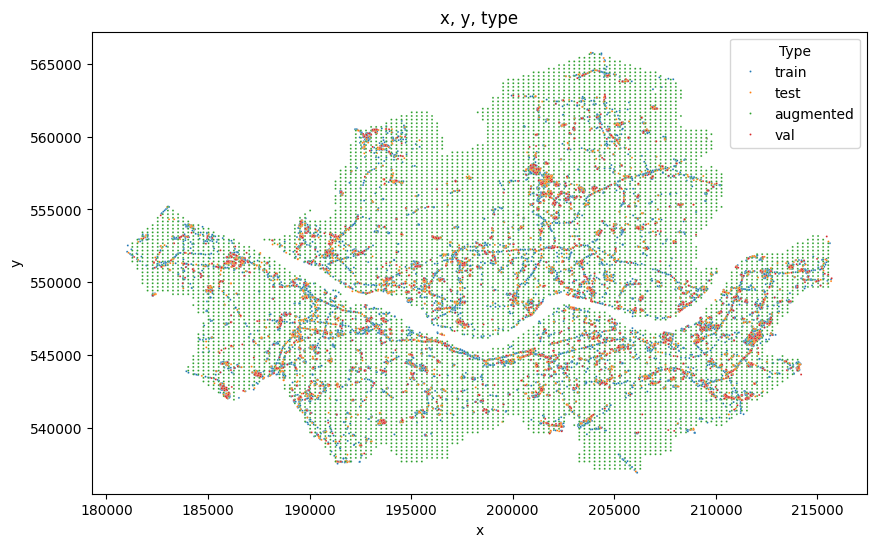

In [8]:
train_df_copy = train_df.copy()
augmented_df_copy = augmented_df.copy()
val_df_copy = val_df.copy()
test_df_copy = test_df.copy()

augmented_df_copy['Type'] = 'augmented'
train_df_copy['Type'] = 'train'
val_df_copy['Type'] = 'val'
test_df_copy['Type'] = 'test'

df_concat = pd.DataFrame(columns=train_df_copy.columns)
df_concat = pd.concat([df_concat, train_df_copy, test_df_copy, augmented_df_copy, val_df_copy])

plot.scatter_relation(df_concat, 'x', 'y', 2, 'x, y, type','Type')

In [9]:
train_df = pd.concat([train_df, augmented_df, val_df])
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21688 entries, 0 to 1581
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              21688 non-null  float64
 1   y              21688 non-null  float64
 2   depth_start    21688 non-null  float64
 3   slope          21688 non-null  float64
 4   aspect         21688 non-null  float64
 5   DEM            21688 non-null  float64
 6   rock_type_1.0  21688 non-null  bool   
 7   rock_type_2.0  21688 non-null  bool   
dtypes: bool(2), float64(6)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              3183 non-null   float64
 1   y              3183 non-null   float64
 2   depth_start    3183 non-null   float64
 3   slope          3183 non-null   float64
 4   aspect         3183 non-null   flo

## Pre-Processing

In [10]:
# # Min Max Scaling: x, y, slope, DEM
# column_to_scale = ['x', 'y', 'slope', 'aspect', 'DEM']

# scaler = MinMaxScaler()

# # train_dataset
# train_df[column_to_scale] = scaler.fit_transform(train_df[column_to_scale])
# train_df['depth_start'] = train_df['depth_start']

# # test_dataset
# test_df[column_to_scale] = scaler.fit_transform(test_df[column_to_scale])
# test_df['depth_start'] = test_df['depth_start']

# display(train_df.describe())
# display(test_df.describe())

In [11]:
# df_concat = pd.DataFrame(columns=train_df.columns)
# df_concat = pd.concat([df_concat, train_df, test_df])
# plot.scatter_relation(df_concat, 'x', 'y', 2, 'x, y min-max_scaling check')

In [12]:
train = TabularDataset(train_df)
test = TabularDataset(test_df)
X_test = TabularDataset(test_df.drop(['depth_start'], axis=1))
y_test = test_df['depth_start'].values.tolist()

## Training-Validation

In [13]:
predictor = TabularPredictor(label='depth_start', 
                             problem_type = 'regression', 
                             eval_metric='r2',
                             verbosity =2 
                             )

predictor.fit(train,
              num_gpus=1,
              time_limit = 3600*24, 
              presets="best_quality", 
              save_space = True, 
              keep_only_best = True,
              save_bag_folds = True,
              ag_args_fit = {'num_gpus': 1} # Train with GPU, # 140 models without gpu, 84 models with gpu during 3600*10(241026), 120 models with gpu during 3600*14(241028)
              )

No path specified. Models will be saved in: "AutogluonModels\ag-20241218_153831"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
Memory Avail:       22.96 GB / 31.93 GB (71.9%)
Disk Space Avail:   485.52 GB / 931.51 GB (52.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

In [14]:
ld_board = predictor.leaderboard(test, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_r145_BAG_L2,0.868590,0.917532,r2,314.545259,406.534418,43514.601007,1.524766,0.464581,344.727547,2,True,113
1,NeuralNetFastAI_r95_BAG_L2,0.868272,0.917564,r2,314.574765,406.547916,43525.188438,1.554271,0.478080,355.314978,2,True,115
2,NeuralNetFastAI_r191_BAG_L2,0.868189,0.917731,r2,314.365729,406.351884,43406.006217,1.345235,0.282047,236.132757,2,True,110
3,WeightedEnsemble_L3,0.868126,0.919061,r2,329.981717,415.837032,45340.315924,0.012002,0.000500,0.312055,3,True,120
4,NeuralNetTorch_r89_BAG_L2,0.867665,0.917084,r2,313.489575,406.241868,43454.087291,0.469081,0.172032,284.213831,2,True,119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,NeuralNetFastAI_r88_BAG_L1,0.674700,0.714423,r2,3.458665,0.081514,91.174769,3.458665,0.081514,91.174769,1,True,66
116,NeuralNetFastAI_r111_BAG_L1,0.662477,0.695942,r2,3.325704,0.075515,58.831319,3.325704,0.075515,58.831319,1,True,62
117,NeuralNetFastAI_r156_BAG_L1,0.657200,0.693613,r2,3.916848,0.073513,70.474973,3.916848,0.073513,70.474973,1,True,41
118,NeuralNetFastAI_r4_BAG_L1,0.629459,0.666637,r2,0.835646,0.212037,182.197649,0.835646,0.212037,182.197649,1,True,96


## Prediction

In [15]:
pred_y = predictor.predict(X_test, ld_board.model[1])

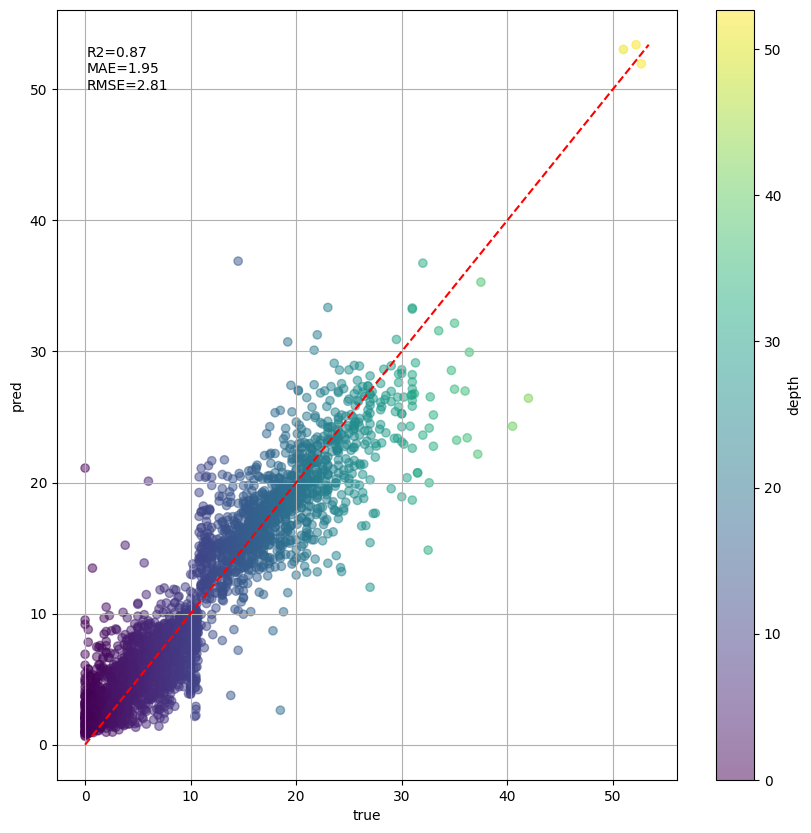

In [16]:
plot.prediction_eval(y_test, pred_y, y_test)